In [2]:
import os, gc, sys, warnings
from glob import glob
import importlib

sys.path.append(r'D:/Storage/Repositories/SeaExplorerTools')
import SXBQ as sx
import BYQtools as byq

# from tqdm.notebook import tqdm
from tqdm import tqdm
from multiprocessing import Pool
from datetime import datetime as dt
    
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv

import gsw

import matplotlib.pyplot as plt
import seaborn as sns
import cmocean.cm as cmo

warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='invalid value encountered in divide')

sns.set(font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'lightgrey',
         'axes.grid': False,
         'axes.labelcolor': 'darkgrey',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': False,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': False,
         'ytick.right': False},
         font_scale=1)

In [3]:
adcp_path = 'D:/Storage/Dropbox/WorkGU/21-06 Oman HAB Deployments/Deployments/221014_Dep9_post/ADCP/sea057_M57.ad2cp.00000*.nc'

In [28]:
BT = xr.open_mfdataset(adcp_path,group='Data/AverageBT')
# BT = BT.sel(time=slice('2022-09-18','2022-09-19')) 

BT = BT.assign_coords(
    Depth=("time", -gsw.z_from_p(BT['Pressure'].values,23)))

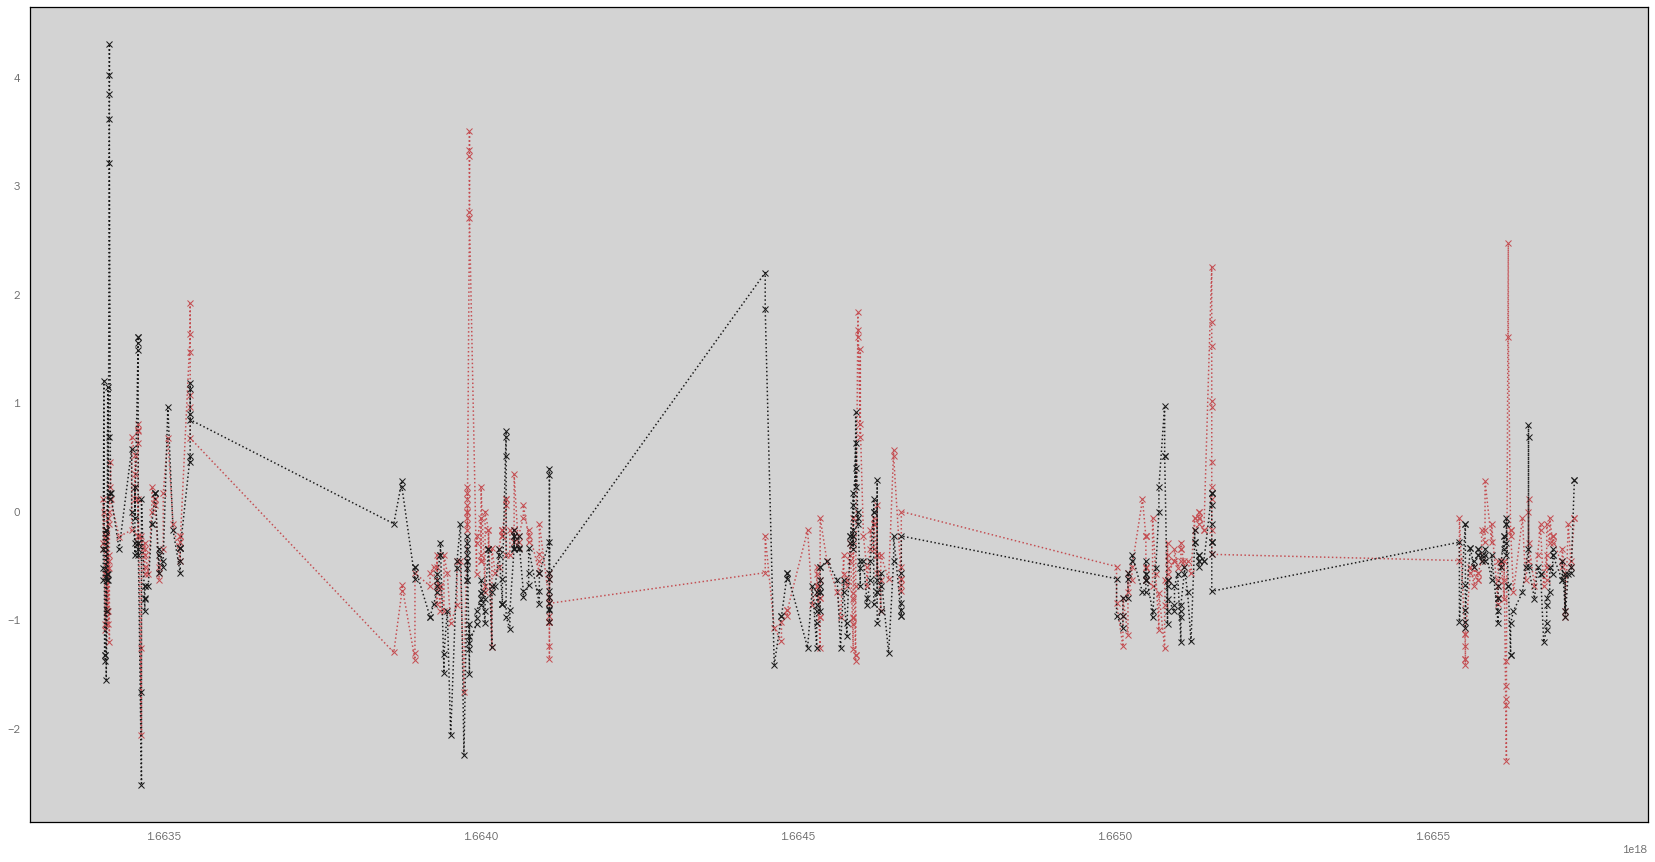

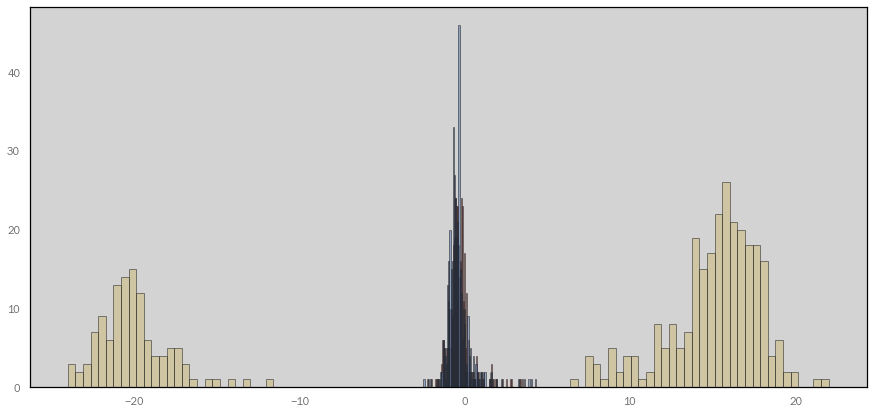

In [5]:
thresh = 12
idx = (BT['FOMBeam1'] < thresh) & (BT['FOMBeam2'] < thresh) & (BT['FOMBeam4'] < thresh) & (BT['DistanceBeam1'] > 2) & (BT['DistanceBeam1'] < 50) & (BT['Pitch'].values  < -15.4) & (BT['Pitch'].values  > -19.4)

plt.figure(figsize=(29,15))

plt.plot(BT['time'].values.astype('float')[idx], (BT['DistanceBeam1'].values-BT['DistanceBeam2'])[idx],':rx')
plt.plot(BT['time'].values.astype('float')[idx], (BT['DistanceBeam4'].values-BT['DistanceBeam2'])[idx],':kx')

plt.figure(figsize=(15,7))

_ = plt.hist((BT['DistanceBeam1'].values-BT['DistanceBeam2'])[idx],100,color='r', alpha=0.5)
_ = plt.hist((BT['DistanceBeam4'].values-BT['DistanceBeam2'])[idx],100,color='b', alpha=0.5)
_ = plt.hist((BT['DistanceBeam3'].values-BT['DistanceBeam2'])[idx],100,color='y', alpha=0.5)

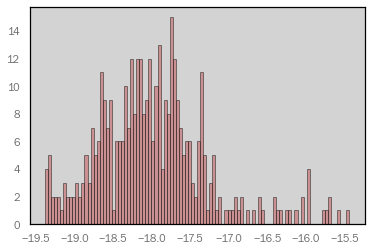

In [6]:
_ = plt.hist((BT['Pitch'])[idx],100,color='r', alpha=0.5)

In [7]:
BT

<xarray.Dataset>
Dimensions:                    (time: 466730, Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 2022-09-17T06:10:13.5587...
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/40)
    TimeStamp                  (time) float64 dask.array<chunksize=(233322,), meta=np.ndarray>
    VelocityBeam1              (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    VelocityBeam2              (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    VelocityBeam3              (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    VelocityBeam4              (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    DistanceBeam1              (time) float64 dask.array<chunksize=(233322,), meta=np.ndarray>
    ...                         ...
    EnsembleCount              (time) float64 dask.array<chunksize=(233322,), meta=np.ndarray>
    WaterTemperature           (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    Pressure                   (time) float64 dask.array<chunksize=(233322,), meta=np.ndarray>
    Heading                    (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    Pitch                      (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>
    Roll                       (time) float32 dask.array<chunksize=(233322,), meta=np.ndarray>

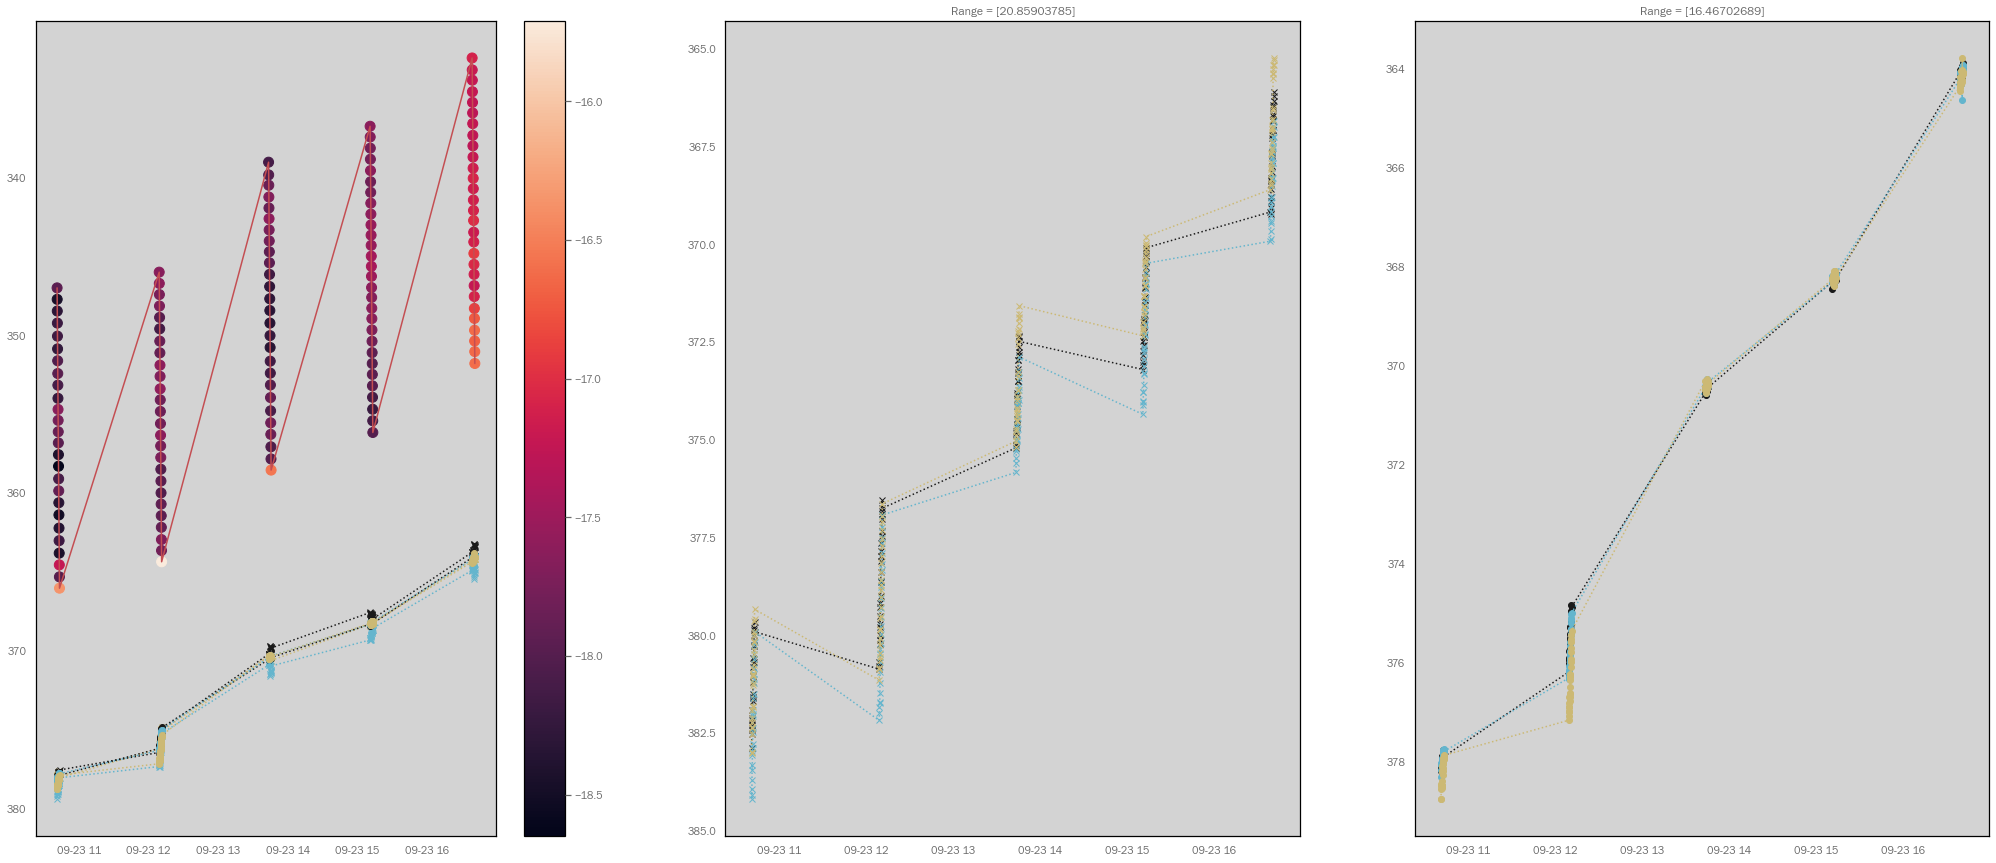

In [67]:
plt.figure(figsize=(35,15))

# BT2 = BT.sel(time=slice('2022-09-23 12:00:00','2022-09-24 04:30:00'))
BT2 = BT.sel(time=slice('2022-09-23 10:00:00','2022-09-23 18:00:00'))
thresh = 120
idx = (BT2['FOMBeam1'] < thresh) & (BT2['FOMBeam2'] < thresh) & (BT2['FOMBeam4'] < thresh) & (BT2['DistanceBeam1'] > 2) & (BT2['DistanceBeam1'] < 50) & (BT2['Pitch'].values  < -15.4) & (BT2['Pitch'].values  > -19.4)


theta_rad_1 = (np.cos(np.deg2rad(47.5 + BT2['Pitch']))  * np.cos(np.deg2rad(BT2['Roll'])))
theta_rad_2 = (np.cos(np.deg2rad(25 +   BT2['Roll'] ))  * np.cos(np.deg2rad(BT2['Pitch'])))
theta_rad_3 = (np.cos(np.deg2rad(47.5 - BT2['Pitch']))  * np.cos(np.deg2rad(BT2['Roll'])))
theta_rad_4 = (np.cos(np.deg2rad(25 -   BT2['Roll'] ))  * np.cos(np.deg2rad(BT2['Pitch'])))

# theta_rad_1 = theta_rad_1[idx]
# theta_rad_2 = theta_rad_2[idx]
# theta_rad_3 = theta_rad_3[idx]
# theta_rad_4 = theta_rad_4[idx]


plt.subplot(131)
plt.plot(BT2['time'].values[idx], BT2['Depth'][idx],'-r')
plt.scatter(BT2['time'].values[idx], BT2['Depth'][idx], 100, BT2['Pitch'][idx])
plt.colorbar()

plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam1'].values*SF  +BT2['Depth'])[idx],':yx')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam2'].values*SF  +BT2['Depth'])[idx],':cx')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam4'].values*SF  +BT2['Depth'])[idx],':kx')

plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam1'].values*theta_rad_1  +BT2['Depth'])[idx],':ko')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam2'].values*theta_rad_2  +BT2['Depth'])[idx],':co')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam4'].values*theta_rad_4  +BT2['Depth'])[idx],':yo')
plt.gca().invert_yaxis()

plt.subplot(132)
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam1'].values  +BT2['Depth'])[idx],':kx')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam2'].values  +BT2['Depth'])[idx],':cx')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam4'].values  +BT2['Depth'])[idx],':yx')
plt.title('Range = '+str(np.diff(plt.ylim())))
plt.gca().invert_yaxis()


plt.subplot(133)
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam1'].values*theta_rad_1  +BT2['Depth'])[idx],':ko')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam2'].values*theta_rad_2  +BT2['Depth'])[idx],':co')
plt.plot(BT2['time'].values[idx], (BT2['DistanceBeam4'].values*theta_rad_4  +BT2['Depth'])[idx],':yo')
plt.title('Range = '+str(np.diff(plt.ylim())))
plt.gca().invert_yaxis()

Distance from ADCP is consistent between front and side beams when at 17.4 degree pitch, meaning all three beams are at equal angles from UP and they are all time gated at the same time, rather than being Z-gated in the 4 beam configuration.

In [48]:
np.cos(np.deg2rad(25 +  0))  * np.cos(np.deg2rad(-17.4)), np.cos(np.deg2rad(47.5 + -17.4))  * np.cos(np.deg2rad(0)), np.cos(np.deg2rad(30))

(0.8648354404387127, 0.8651514205697045, 0.8660254037844387)